This file was built upon an earlier version of training. Some of the earlier cells are for training. The testing and data analysis part are towards the end - please keep scrolling.

In [ ]:
!pip install stable_baselines3
!pip install sb3_contrib
!pip install simglucose

## ENV

In [ ]:
###################################
# This is for training, not testing
###################################
# This the enviroment that the model was trained on, to check generalization you should change the patient names so that it check with the patients that it hasn't seen before
# Also test with this enviroment (adult patients 1-5), and the untrained ones (adult patients 6-10)
from simglucose.simulation.scenario_gen import RandomScenario
from datetime import datetime
from simglucose.simulation.scenario import CustomScenario

now = datetime.now()
start_time = datetime.combine(now.date(), datetime.min.time())

patient_name = [#These 5 patients are for training.
    "adult#001",
    "adult#002",
    "adult#003",
    "adult#004",
    "adult#005",
]

#scenario = RandomScenario(start_time=start_time, seed=1)
scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]              # you can give then a custom meal plan if you want
scenario = CustomScenario(start_time=start_time, scenario=scen)
from gymnasium.envs.registration import register
register(
    id="simglucose_attn",
    entry_point="simglucose.envs:T1DSimGymnaisumEnv",
    max_episode_steps=480,  # ~24 hours at 3-min steps, adjust as needed
    kwargs={"patient_name": patient_name,
            "custom_scenario": scenario},
)

In [ ]:
import gymnasium
from gymnasium.spaces import Box as GymnasiumBox
import numpy as np

# Custom wrapper to modify observation space
class CustomSimglucoseWrapper(gymnasium.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        low = np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float32)  # [CGM, last_insulin, meal, hour]
        high = np.array([2, 1, 4, 23.0/23], dtype=np.float32)
        self.observation_space = GymnasiumBox(low, high)
        self.last_insulin = 0.0

        self.action_space = GymnasiumBox(
            low=np.array([0.0], dtype=np.float32),
            high=np.array([1.0], dtype=np.float32)
        )


    def reset(self, **kwargs):
        cgm,info = self.env.reset(**kwargs)
        meal = info['meal']
        hour = info['time'].hour
        self.last_insulin = 0.0
        obs = obs = np.array([cgm[0]/300, self.last_insulin/0.1, meal/50, hour/23], dtype=np.float32)
        return obs, {}

    def step(self, action):
        scaled_action = float(np.clip(action[0], 0.0, 1.0)) * 0.1
        self.last_insulin = scaled_action

        cgm, reward, terminated, truncated, info = self.env.step(scaled_action)

        bg = info['bg']
        meal = info['meal']
        hour = info['time'].hour
        obs = np.array([cgm[0]/300, self.last_insulin/0.1, meal/50, hour/23], dtype=np.float32)

        if bg < 54 or bg > 300:
          terminated = True

        return obs, reward, bool(terminated), bool(truncated), info

## policy model

In [ ]:
from typing import Any, Optional, Union, Dict, List, Tuple

import numpy as np
import torch as th
from gymnasium import spaces
from stable_baselines3.common.distributions import Distribution
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.torch_layers import (
    BaseFeaturesExtractor,
    FlattenExtractor,
    MlpExtractor,
)
from stable_baselines3.common.type_aliases import Schedule
from stable_baselines3.common.utils import zip_strict
from torch import nn

from sb3_contrib.common.recurrent.type_aliases import RNNStates
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

class FeatureAttention(nn.Module):
    """
    Get attention and attention features
    dynamic attention weights for each observation.
    """
    def __init__(self, feature_dim: int):
        super().__init__()
        # Dense layer to calculate attention weights
        self.attention_layer = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.ReLU(),
            nn.Linear(feature_dim // 2, feature_dim),
            nn.Softmax(dim=-1)
        )

        # Store last calculated weights for explainability
        self.last_attention_weights = None

    def forward(self, x: th.Tensor) -> th.Tensor:
        """
        Apply observation-specific feature attention.

        inputs:
            x: Input tensor with shape (batch_size, feature_dim)

        Returns:
            Weighted features with shape (batch_size, feature_dim)
        """
        # Calculate attention weights for each observation in batch
        attention_weights = self.attention_layer(x)

        # print("attn weights:", attention_weights)
        # Store for later retrieval (saving last batch)
        self.last_attention_weights = attention_weights

        # Apply attention weights to features
        weighted_features = x * attention_weights

        return weighted_features

    def get_attention_weights(self, batch_idx: int = 0) -> th.Tensor:
        """
        Get the attention weights for a specific observation in the last batch.

        Input:
            batch_idx: Index of the observation in the batch

        Returns:
            Attention weights tensor
        """
        if self.last_attention_weights is None:
            raise ValueError("No attention weights calculated yet. Run a forward pass first.")

        # Return weights for the specified observation
        return self.last_attention_weights[batch_idx]


class AttentionFeaturesExtractor(BaseFeaturesExtractor):
    """
    Create a richer representation vector to be sent to the Recurrent PPO.
    Changes the type to BaseFeaturesExtractor to be applied in the AttentionLstmPPOPolicy for sb3_contrib Recurrent PPO.

    """
    def __init__(
        self,
        observation_space: spaces.Space,
        features_dim: int = 64,
    ):
        super().__init__(observation_space, features_dim)

        n_input_features = int(np.prod(observation_space.shape))

        # Attention layer for input features
        self.attention = FeatureAttention(n_input_features)

        # Feature processing layers (after attention)
        self.feature_layers = nn.Sequential(
            nn.Linear(n_input_features, features_dim),
            nn.ReLU(),
            nn.Linear(features_dim, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: th.Tensor) -> th.Tensor:
        # Apply attention to raw features first
        attended_features = self.attention(observations)

        # Then process through the feature layers
        features = self.feature_layers(attended_features)

        return features


# taken and modified from: https://github.com/Stable-Baselines-Team/stable-baselines3-contrib/blob/master/sb3_contrib/common/recurrent/policies.py
# Added the attention retrieval

class AttentionLstmPPOPolicy(RecurrentActorCriticPolicy):
    """
    Recurrent policy class for actor-critic algorithms with attention mechanism for explainability.
    To be used with RecurrentPPO.

    :param observation_space: Observation space
    :param action_space: Action space
    :param lr_schedule: Learning rate schedule (could be constant)
    :param net_arch: The specification of the policy and value networks.
    :param activation_fn: Activation function
    :param ortho_init: Whether to use or not orthogonal initialization
    :param use_sde: Whether to use State Dependent Exploration or not
    :param log_std_init: Initial value for the log standard deviation
    :param full_std: Whether to use (n_features x n_actions) parameters
        for the std instead of only (n_features,) when using gSDE
    :param use_expln: Use ``expln()`` function instead of ``exp()`` to ensure
        a positive standard deviation (cf paper). It allows to keep variance
        above zero and prevent it from growing too fast. In practice, ``exp()`` is usually enough.
    :param squash_output: Whether to squash the output using a tanh function,
        this allows to ensure boundaries when using gSDE.
    :param features_extractor_class: Features extractor to use.
    :param features_extractor_kwargs: Keyword arguments
        to pass to the features extractor.
    :param share_features_extractor: If True, the features extractor is shared between the policy and value networks.
    :param normalize_images: Whether to normalize images or not,
         dividing by 255.0 (True by default)
    :param optimizer_class: The optimizer to use,
        ``th.optim.Adam`` by default
    :param optimizer_kwargs: Additional keyword arguments,
        excluding the learning rate, to pass to the optimizer
    :param lstm_hidden_size: Number of hidden units for each LSTM layer.
    :param n_lstm_layers: Number of LSTM layers.
    :param shared_lstm: Whether the LSTM is shared between the actor and the critic
        (in that case, only the actor gradient is used)
        By default, the actor and the critic have two separate LSTM.
    :param enable_critic_lstm: Use a seperate LSTM for the critic.
    :param lstm_kwargs: Additional keyword arguments to pass the the LSTM
        constructor.
    """

    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Schedule,
        net_arch: Optional[Union[list[int], dict[str, list[int]]]] = None,
        activation_fn: type[nn.Module] = nn.Tanh,
        ortho_init: bool = True,
        use_sde: bool = False,
        log_std_init: float = 0.0,
        full_std: bool = True,
        use_expln: bool = False,
        squash_output: bool = False,
        features_extractor_class: type[BaseFeaturesExtractor] = AttentionFeaturesExtractor,
        features_extractor_kwargs: Optional[dict[str, Any]] = None,
        share_features_extractor: bool = True,
        normalize_images: bool = True,
        optimizer_class: type[th.optim.Optimizer] = th.optim.Adam,
        optimizer_kwargs: Optional[dict[str, Any]] = None,
        lstm_hidden_size: int = 256,
        n_lstm_layers: int = 1,
        shared_lstm: bool = False,
        enable_critic_lstm: bool = True,
        lstm_kwargs: Optional[dict[str, Any]] = None,
    ):
        # Initialize with parent class
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            ortho_init,
            use_sde,
            log_std_init,
            full_std,
            use_expln,
            squash_output,
            features_extractor_class,
            features_extractor_kwargs,
            share_features_extractor,
            normalize_images,
            optimizer_class,
            optimizer_kwargs,
            lstm_hidden_size,
            n_lstm_layers,
            shared_lstm,
            enable_critic_lstm,
            lstm_kwargs,
        )

        # Access the attention layer from the features extractor
        if hasattr(self.features_extractor, 'attention'):
            self.attention = self.features_extractor.attention
        else:
            # Fallback if the features extractor was overridden (just in case)
            self.attention = None

    @property
    def feature_names(self) -> List[str]:
        """
        Return the feature names for explainability.
        This should be customized based on your environment.
        used @property decorator to turn into read only attribute. Ensuring no accidental changes/overwriting.

        """

        return ["CGM", "Last_Insulin", "Meal", "Hour"]

    def get_attention_weights(self) -> th.Tensor:
        """
        Get the attention weights from the feature attention.
        """
        if self.attention is None:
            raise ValueError("Attention mechanism not available in this policy.")
        return self.attention.get_attention_weights()

    def explain(self, obs: np.ndarray) -> Dict[str, float]:
        """
        Return feature importance as a dictionary.

        Inputs:
            obs: Observation (state)

        Returns:
            Dictionary mapping feature names to their importance scores
        """
        # Convert observation to tensor
        device = self.device
        obs_tensor = th.as_tensor(obs).float().to(device)

        # Ensure proper shape
        if len(obs_tensor.shape) == 1:
            obs_tensor = obs_tensor.unsqueeze(0)

        # Just extract features to trigger attention computation
        with th.no_grad():
            # Use the extract_features method directly without requiring LSTM states
            _ = self.features_extractor(obs_tensor)

        # Get attention weights
        if not hasattr(self, 'attention') or self.attention is None:
            raise ValueError("This policy doesn't have an attention mechanism")

        attention_weights = self.attention.get_attention_weights().detach().cpu().numpy()
        # print("attn Weights:", attention_weights)

        # Matching weights with feature names
        feature_names = self.feature_names

        # Handling potental dimension mismatch
        if len(feature_names) !=len(attention_weights):
            print(f"Warning: feature_names length ({len(feature_names)}) doesn't match "
                  f"attention_weights length ({len(attention_weights)})")
            # Truncate the longer one
            min_len = min(len(feature_names), len(attention_weights))
            feature_names = feature_names[:min_len]
            attention_weights = attention_weights[:min_len]

        feature_importance = dict(zip(feature_names, attention_weights.flatten()))

        return feature_importance


# Modified R-PPO architecture kwargs
def create_attention_lstm_policy():
    policy_kwargs = dict(
        features_extractor_class=AttentionFeaturesExtractor,
        features_extractor_kwargs=dict(features_dim=64),
        net_arch=dict(
            pi=[64, 64],
            vf=[64, 64]
        ),
    )

    return AttentionLstmPPOPolicy, policy_kwargs

# [ [ [Testing and data analysis starts here] ] ]

In [ ]:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


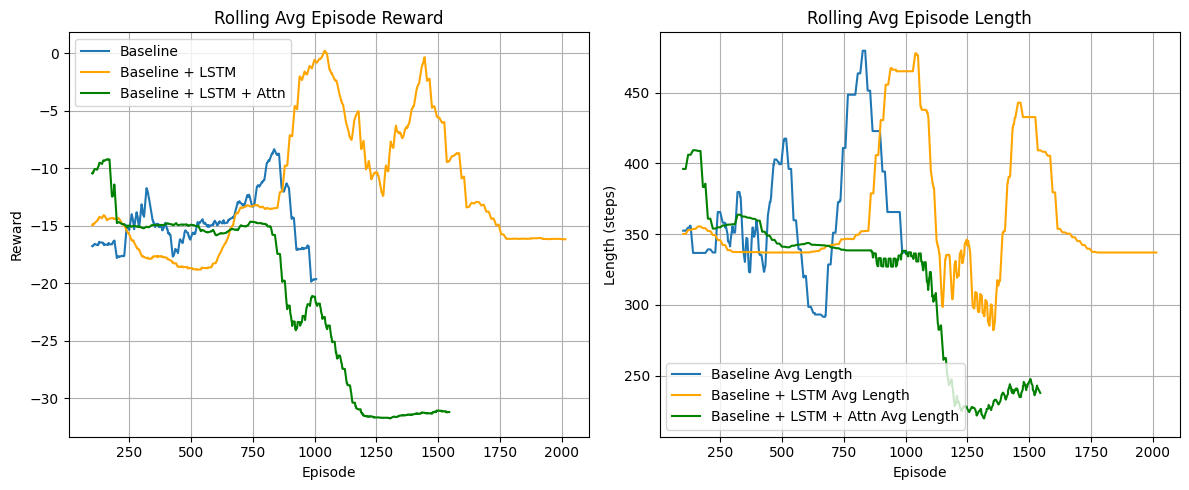

In [ ]:
##### This cell visualizes the training log files to reveal the quality of training
import pandas as pd
import matplotlib.pyplot as plt

# List of file paths
file_paths = [
    "/content/drive/MyDrive/9CSC2516/Logs/baseline_PPO_3.csv.monitor-2.csv", # Baseline (PPO)
    "/content/drive/MyDrive/9CSC2516/Logs/baseline_PPO.csv.monitor.csv", # Baseline + LSTM (Recurrent PPO)
    "/content/drive/MyDrive/9CSC2516/Logs/model_5_.monitor.csv"  # Baseline + LSTM + Attn (Attention Recurrent PPO)
]

labels = ['Baseline', 'Baseline + LSTM', 'Baseline + LSTM + Attn']
colors = ['tab:blue', 'orange', 'green']  # Optional: for visual distinction

plt.figure(figsize=(12, 5))

# Reward subplot
plt.subplot(1, 2, 1)
for path, label, color in zip(file_paths, labels, colors):
    df = pd.read_csv(path, skiprows=1)
    rolling_reward = df["r"].rolling(window=100).mean()
    plt.plot(rolling_reward, label=f"{label}", color=color)

plt.title("Rolling Avg Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()

# Episode length subplot
plt.subplot(1, 2, 2)
for path, label, color in zip(file_paths, labels, colors):
    df = pd.read_csv(path, skiprows=1)
    rolling_length = df["l"].rolling(window=100).mean()
    plt.plot(rolling_length, label=f"{label} Avg Length", color=color)

plt.title("Rolling Avg Episode Length")
plt.xlabel("Episode")
plt.ylabel("Length (steps)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Data analysis for Attn Recurrent PPO (Baseline+LSTM+attention).
import pandas as pd
import os
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO
from simglucose.simulation.scenario_gen import RandomScenario
from datetime import datetime
from simglucose.simulation.scenario import CustomScenario
from gymnasium.envs.registration import register
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="gymnasium.envs.registration")

# Load the Attn Recurrent PPO (Baseline+LSTM+attention)
model_dir = "/content/drive/MyDrive/9CSC2516/models/Best_model_5.zip"
model = RecurrentPPO.load(model_dir, custom_objects={"policy": AttentionLstmPPOPolicy})

# Set up environment, including patients and meals
# Will test patients individually (trained on #1-5, and will test generalizability on #6-10).
now = datetime.now()
start_time = datetime.combine(now.date(), datetime.min.time())
patients = ["adult#001","adult#002","adult#003","adult#004","adult#005","adult#006","adult#007","adult#008","adult#009","adult#010",]

# scenario = RandomScenario(start_time=start_time, seed=1)
# meal plan
scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]
scenario = CustomScenario(start_time=start_time, scenario=scen)

rows_by_j = {}
withinrange = {}
rewards = {}
terminate = {}
# iterate through patients 1-10
for i in range (10):
    register(
        id="simglucose_test",
        entry_point="simglucose.envs:T1DSimGymnaisumEnv",
        max_episode_steps=480,  # ~24 hours at 3-min steps, adjust as needed
        kwargs={"patient_name": patients[i],
                "custom_scenario": scenario},)
    # Get action
    base_env = gymnasium.make("simglucose_test")
    env = CustomSimglucoseWrapper(base_env)
    obs, _ = env.reset()
    lstm_states = None

    episode_reward = 0
    count_control = 0
    termination_count = 0
    # iterate through 24 hours
    for j in range(479):
        action, lstm_states = model.predict(obs, state=lstm_states, deterministic=True)   # Deterministic for consistency
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        # obtain blood glucose, and track if it is outside target range [70, 180]
        bg = obs[0]*300
        if bg >= 70 and bg <= 180:
          count_control += 1
        # save data by timestamp and patient
        if j not in rows_by_j:
            rows_by_j[j] = {}
        rows_by_j[j].update({
            f"pt_{i+1}_index": j+1,
            f"pt_{i+1}_BG": bg,
            f"pt_{i+1}_meal": obs[-2]*50,
            f"pt_{i+1}_insulin": action[0],
            f"pt_{i+1}_reward": reward})
        # save feature importance
        feature_importance = model.policy.explain(obs)
        prefixed_features = {f"pt_{i+1}_weight_{k}": v for k, v in feature_importance.items()}
        rows_by_j[j].update(prefixed_features)
        # terminate if blood glucose in dangerous range (as specified in policy, outside [54, 300])
        if terminated or truncated:
          termination_count += 1
          break
    print(f"Patient {i+1}:")
    withinrange[i] = count_control/479
    print(f"Within target range: {withinrange[i]*100:.2f}%")
    rewards[i] = episode_reward
    print(f"Total Reward: {episode_reward:.2f}")
    terminate[i] = termination_count
    print(f"Termination count: {termination_count}")

    env.close()

# save to CSV file
df = pd.DataFrame(list(rows_by_j.values()))
save_dir = "/content/drive/MyDrive/9CSC2516/result-I"
os.makedirs(save_dir, exist_ok=True)
file_path = os.path.join(save_dir, "baseline+LSTM+attn.csv")
df.to_csv(file_path, index=False)

# printout statistics
print("WITHIN RANGE")
subset1 = list(withinrange.values())[0:5]       # elements 0 to 4
subset2 = list(withinrange.values())[5:9]      # elements 5 to 9
subset3 = list(withinrange.values())[0:9]      # all elements

print("Patient 1-5")
mean = np.mean(subset1)
variance = np.var(subset1, ddof=1)  # sample variance
sem = np.std(subset1, ddof=1) / np.sqrt(len(subset1))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("Patient 6-10")
mean = np.mean(subset2)
variance = np.var(subset2, ddof=1)  # sample variance
sem = np.std(subset2, ddof=1) / np.sqrt(len(subset2))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("All patients")
mean = np.mean(subset3)
variance = np.var(subset3, ddof=1)  # sample variance
sem = np.std(subset3, ddof=1) / np.sqrt(len(subset3))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("REWARDS")
subset1 = list(rewards.values())[0:5]       # elements 0 to 4
subset2 = list(rewards.values())[5:9]      # elements 5 to 9
subset3 = list(rewards.values())[0:9]      # all elements

print("Patient 1-5")
mean = np.mean(subset1)
variance = np.var(subset1, ddof=1)  # sample variance
sem = np.std(subset1, ddof=1) / np.sqrt(len(subset1))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("Patient 6-10")
mean = np.mean(subset2)
variance = np.var(subset2, ddof=1)  # sample variance
sem = np.std(subset2, ddof=1) / np.sqrt(len(subset2))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("All patients")
mean = np.mean(subset3)
variance = np.var(subset3, ddof=1)  # sample variance
sem = np.std(subset3, ddof=1) / np.sqrt(len(subset3))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")


Patient 1:
Within target range: 97.08%
Total Reward: 0.41
Termination count: 0
Patient 2:
Within target range: 96.45%
Total Reward: 0.62
Termination count: 0
Patient 3:
Within target range: 81.21%
Total Reward: 1.57
Termination count: 0
Patient 4:
Within target range: 13.36%
Total Reward: -17.78
Termination count: 1
Patient 5:
Within target range: 70.15%
Total Reward: -5.88
Termination count: 0
Patient 6:
Within target range: 68.89%
Total Reward: -2.59
Termination count: 0
Patient 7:
Within target range: 15.24%
Total Reward: -18.64
Termination count: 1
Patient 8:
Within target range: 39.25%
Total Reward: -8.41
Termination count: 1
Patient 9:
Within target range: 66.18%
Total Reward: -10.89
Termination count: 0
Patient 10:
Within target range: 66.18%
Total Reward: 3.43
Termination count: 0
WITHIN RANGE
Patient 1-5
Mean: 0.7164926931106472
Variance: 0.11882226803404794
SEM: 0.154157236634579
Patient 6-10
Mean: 0.511482254697286
Variance: 0.054944408366421
SEM: 0.10482786687367152
All pat

In [ ]:
# Data analysis for Recurrent PPO (Baseline+LSTM, no attention).
import pandas as pd
import os
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO
from simglucose.simulation.scenario_gen import RandomScenario
from datetime import datetime
from simglucose.simulation.scenario import CustomScenario
from gymnasium.envs.registration import register
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="gymnasium.envs.registration")

# Load the Recurrent PPO model with LSTM but no attention
model_dir = "/content/drive/MyDrive/9CSC2516/models/Best_baseline_RPPO.zip"
model = RecurrentPPO.load(model_dir)

# Set up environment, including patients and meals
# Will test patients individually (trained on #1-5, and will test generalizability on #6-10).
now = datetime.now()
start_time = datetime.combine(now.date(), datetime.min.time())
patients = ["adult#001","adult#002","adult#003","adult#004","adult#005","adult#006","adult#007","adult#008","adult#009","adult#010",]

# scenario = RandomScenario(start_time=start_time, seed=1)
# meal plan
scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]
scenario = CustomScenario(start_time=start_time, scenario=scen)

rows_by_j = {}
withinrange = {}
rewards = {}
terminate = {}
# iterate through patients 1-10
for i in range (10):
    register(
        id="simglucose_test",
        entry_point="simglucose.envs:T1DSimGymnaisumEnv",
        max_episode_steps=480,  # ~24 hours at 3-min steps, adjust as needed
        kwargs={"patient_name": patients[i],
                "custom_scenario": scenario},)
    # Get action
    base_env = gymnasium.make("simglucose_test")
    env = CustomSimglucoseWrapper(base_env)
    obs, _ = env.reset()
    lstm_states = None


    episode_reward = 0
    count_control = 0
    termination_count = 0
    # iterate through 24 hours
    for j in range(479):
        action, lstm_states = model.predict(obs, state=lstm_states, deterministic=True)   # Deterministic for consistency
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        # obtain blood glucose, and track if it is outside targeted range [70, 180]
        bg = obs[0]*300
        if bg >= 70 and bg <= 180:
          count_control += 1
        # save data by timestamp and patient
        if j not in rows_by_j:
            rows_by_j[j] = {}
        rows_by_j[j].update({
            f"pt_{i+1}_index": j+1,
            f"pt_{i+1}_BG": bg,
            f"pt_{i+1}_meal": obs[-2]*50,
            f"pt_{i+1}_insulin": action[0],
            f"pt_{i+1}_reward": reward})
        # terminate if blood glucose in dangerous range (as specified in policy)
        if terminated or truncated:
          termination_count += 1
          break

    print(f"Patient {i+1}:")
    withinrange[i] = count_control/479
    print(f"Within target range: {withinrange[i]*100:.2f}%")
    rewards[i] = episode_reward
    print(f"Total Reward: {episode_reward:.2f}")
    terminate[i] = termination_count
    print(f"Termination count: {termination_count}")

    env.close()

# save to CSV file
df = pd.DataFrame(list(rows_by_j.values()))
save_dir = "/content/drive/MyDrive/9CSC2516/result-I"
os.makedirs(save_dir, exist_ok=True)
file_path = os.path.join(save_dir, "baseline+LSTM.csv")
df.to_csv(file_path, index=False)

# printout statistics
print("WITHIN RANGE")
subset1 = list(withinrange.values())[0:5]       # elements 0 to 4
subset2 = list(withinrange.values())[5:9]      # elements 5 to 9
subset3 = list(withinrange.values())[0:9]      # all elements

print("Patient 1-5")
mean = np.mean(subset1)
variance = np.var(subset1, ddof=1)  # sample variance
sem = np.std(subset1, ddof=1) / np.sqrt(len(subset1))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("Patient 6-10")
mean = np.mean(subset2)
variance = np.var(subset2, ddof=1)  # sample variance
sem = np.std(subset2, ddof=1) / np.sqrt(len(subset2))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("All patients")
mean = np.mean(subset3)
variance = np.var(subset3, ddof=1)  # sample variance
sem = np.std(subset3, ddof=1) / np.sqrt(len(subset3))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("REWARDS")
subset1 = list(rewards.values())[0:5]       # elements 0 to 4
subset2 = list(rewards.values())[5:9]      # elements 5 to 9
subset3 = list(rewards.values())[0:9]      # all elements

print("Patient 1-5")
mean = np.mean(subset1)
variance = np.var(subset1, ddof=1)  # sample variance
sem = np.std(subset1, ddof=1) / np.sqrt(len(subset1))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("Patient 6-10")
mean = np.mean(subset2)
variance = np.var(subset2, ddof=1)  # sample variance
sem = np.std(subset2, ddof=1) / np.sqrt(len(subset2))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("All patients")
mean = np.mean(subset3)
variance = np.var(subset3, ddof=1)  # sample variance
sem = np.std(subset3, ddof=1) / np.sqrt(len(subset3))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

Patient 1:
Within target range: 100.00%
Total Reward: 1.30
Termination count: 0
Patient 2:
Within target range: 98.96%
Total Reward: -0.20
Termination count: 0
Patient 3:
Within target range: 77.04%
Total Reward: 0.79
Termination count: 0
Patient 4:
Within target range: 12.73%
Total Reward: -8.88
Termination count: 1
Patient 5:
Within target range: 60.54%
Total Reward: -3.28
Termination count: 0
Patient 6:
Within target range: 64.30%
Total Reward: -5.71
Termination count: 0
Patient 7:
Within target range: 14.41%
Total Reward: -13.28
Termination count: 1
Patient 8:
Within target range: 89.35%
Total Reward: 1.05
Termination count: 0
Patient 9:
Within target range: 59.71%
Total Reward: -4.77
Termination count: 0
Patient 10:
Within target range: 61.38%
Total Reward: 3.13
Termination count: 0
WITHIN RANGE
Patient 1-5
Mean: 0.6985386221294363
Variance: 0.12891462293138542
SEM: 0.16057062180323362
Patient 6-10
Mean: 0.5782881002087683
Variance: 0.07343500071913912
SEM: 0.12118993416875767
All

In [ ]:
# Data analysis for PPO (Baseline, no LSTM or attention).
import pandas as pd
import os
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO
from simglucose.simulation.scenario_gen import RandomScenario
from datetime import datetime
from simglucose.simulation.scenario import CustomScenario
from gymnasium.envs.registration import register
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="gymnasium.envs.registration")

# Load the baseline PPO model with no LSTM or attention
model_dir = "/content/drive/MyDrive/9CSC2516/models/best_baseline_ppo_3.zip"
model = PPO.load(model_dir)

# Set up environment, including patients and meals
# Will test patients individually (trained on #1-5, and will test generalizability on #6-10).
now = datetime.now()
start_time = datetime.combine(now.date(), datetime.min.time())
patients = ["adult#001","adult#002","adult#003","adult#004","adult#005","adult#006","adult#007","adult#008","adult#009","adult#010",]

# scenario = RandomScenario(start_time=start_time, seed=1)
# meal plan
scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10)]
scenario = CustomScenario(start_time=start_time, scenario=scen)

rows_by_j = {}
withinrange = {}
rewards = {}
terminate = {}
# iterate through patients 1-10
for i in range (10):
    register(
        id="simglucose_test",
        entry_point="simglucose.envs:T1DSimGymnaisumEnv",
        max_episode_steps=480,  # ~24 hours at 3-min steps, adjust as needed
        kwargs={"patient_name": patients[i],
                "custom_scenario": scenario},)
    # Get action
    base_env = gymnasium.make("simglucose_test")
    env = CustomSimglucoseWrapper(base_env)
    obs, _ = env.reset()
    lstm_states = None

    episode_reward = 0
    count_control = 0
    termination_count = 0
    # iterate through 24 hours
    for j in range(479):
        action, lstm_states = model.predict(obs, state=lstm_states, deterministic=True)   # Deterministic for consistency
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        # obtain blood glucose, and track if it is outside targeted range [70, 180]
        bg = obs[0]*300
        if bg >= 70 and bg <= 180:
          count_control += 1
        # save data by timestamp and patient
        if j not in rows_by_j:
            rows_by_j[j] = {}
        rows_by_j[j].update({
            f"pt_{i+1}_index": j+1,
            f"pt_{i+1}_BG": bg,
            f"pt_{i+1}_meal": obs[-2]*50,
            f"pt_{i+1}_insulin": action[0],
            f"pt_{i+1}_reward": reward})
        # terminate if blood glucose in dangerous range (as specified in policy)
        if terminated or truncated:
          termination_count += 1
          break

    print(f"Patient {i+1}:")
    withinrange[i] = count_control/479
    print(f"Within target range: {withinrange[i]*100:.2f}%")
    rewards[i] = episode_reward
    print(f"Total Reward: {episode_reward:.2f}")
    terminate[i] = termination_count
    print(f"Termination count: {termination_count}")

    env.close()

# save to CSV file
df = pd.DataFrame(list(rows_by_j.values()))
save_dir = "/content/drive/MyDrive/9CSC2516/result-I"
os.makedirs(save_dir, exist_ok=True)
file_path = os.path.join(save_dir, "baseline.csv")
df.to_csv(file_path, index=False)

# Statistics printout
print("WITHIN RANGE")
subset1 = list(withinrange.values())[0:5]       # elements 0 to 4
subset2 = list(withinrange.values())[5:9]      # elements 5 to 9
subset3 = list(withinrange.values())[0:9]      # all elements

print("Patient 1-5")
mean = np.mean(subset1)
variance = np.var(subset1, ddof=1)  # sample variance
sem = np.std(subset1, ddof=1) / np.sqrt(len(subset1))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("Patient 6-10")
mean = np.mean(subset2)
variance = np.var(subset2, ddof=1)  # sample variance
sem = np.std(subset2, ddof=1) / np.sqrt(len(subset2))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("All patients")
mean = np.mean(subset3)
variance = np.var(subset3, ddof=1)  # sample variance
sem = np.std(subset3, ddof=1) / np.sqrt(len(subset3))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("REWARDS")
subset1 = list(rewards.values())[0:5]       # elements 0 to 4
subset2 = list(rewards.values())[5:9]      # elements 5 to 9
subset3 = list(rewards.values())[0:9]      # all elements

print("Patient 1-5")
mean = np.mean(subset1)
variance = np.var(subset1, ddof=1)  # sample variance
sem = np.std(subset1, ddof=1) / np.sqrt(len(subset1))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("Patient 6-10")
mean = np.mean(subset2)
variance = np.var(subset2, ddof=1)  # sample variance
sem = np.std(subset2, ddof=1) / np.sqrt(len(subset2))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

print("All patients")
mean = np.mean(subset3)
variance = np.var(subset3, ddof=1)  # sample variance
sem = np.std(subset3, ddof=1) / np.sqrt(len(subset3))  # standard error of the mean
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"SEM: {sem}")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Patient 1:
Within target range: 54.49%
Total Reward: 4.74
Termination count: 0
Patient 2:
Within target range: 53.24%
Total Reward: -5.85
Termination count: 0
Patient 3:
Within target range: 13.15%
Total Reward: -32.14
Termination count: 1
Patient 4:
Within target range: 9.60%
Total Reward: -28.66
Termination count: 1
Patient 5:
Within target range: 33.82%
Total Reward: -0.42
Termination count: 0
Patient 6:
Within target range: 13.99%
Total Reward: -35.51
Termination count: 1
Patient 7:
Within target range: 10.44%
Total Reward: -32.54
Termination count: 1
Patient 8:
Within target range: 15.45%
Total Reward: -36.63
Termination count: 1
Patient 9:
Within target range: 26.72%
Total Reward: -7.36
Termination count: 0
Patient 10:
Within target range: 21.92%
Total Reward: -31.25
Termination count: 1
WITHIN RANGE
Patient 1-5
Mean: 0.32860125260960327
Variance: 0.04532886450111357
SEM: 0.0952143523856709
Patient 6-10
Mean: 0.16649269311064718
Variance: 0.004952253520512898
SEM: 0.0351861248239

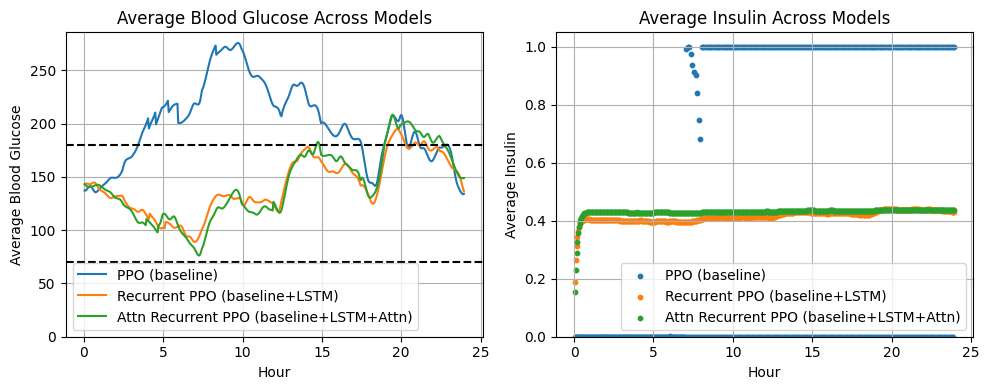

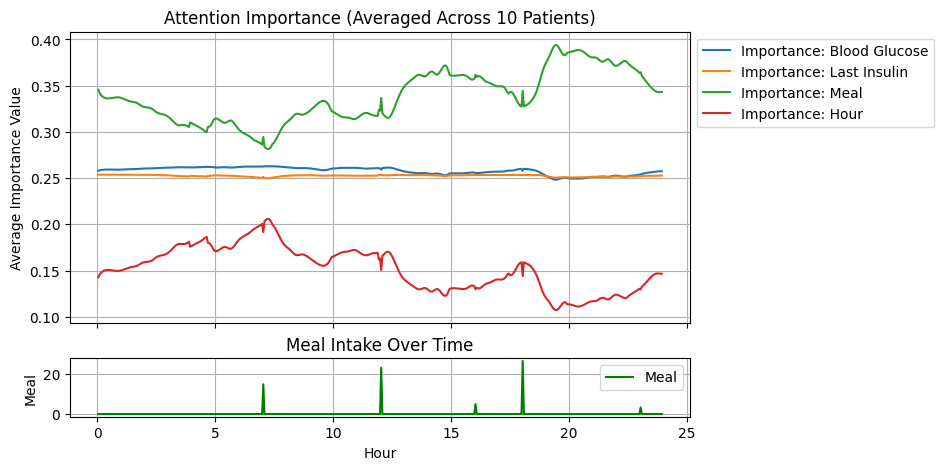

In [ ]:
# Plotting results based on data collected from 3 models, that has been saved to individual CSV files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# File paths
folder = "/content/drive/MyDrive/9CSC2516/result-I"
files = {
    "PPO (baseline)": f"{folder}/baseline.csv",
    "Recurrent PPO (baseline+LSTM)": f"{folder}/baseline+LSTM.csv",
    "Attn Recurrent PPO (baseline+LSTM+Attn)": f"{folder}/baseline+LSTM+attn.csv"
}

# Load all model result files
dfs = {name: pd.read_csv(path) for name, path in files.items()}

# Plot BG and Insulin Side by Side (in hours)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for name, df in dfs.items():
    x = df["pt_1_index"] / 20
    bg_cols = [f"pt_{i}_BG" for i in range(1, 10)]
    bg_avg = df[bg_cols].mean(axis=1)
    ax1.plot(x, bg_avg, label=name)

ax1.axhline(y=70, color='black', linestyle='--')
ax1.axhline(y=180, color='black', linestyle='--')
ax1.set_xlabel("Hour")
ax1.set_ylabel("Average Blood Glucose")
ax1.set_title("Average Blood Glucose Across Models")
ax1.set_ylim(bottom=0)
ax1.grid(True)
ax1.legend()

for name, df in dfs.items():
    x = df["pt_1_index"] / 20
    insulin_cols = [f"pt_{i}_insulin" for i in range(1, 10)]
    insulin_avg = df[insulin_cols].mean(axis=1)
    ax2.scatter(x, insulin_avg, label=name, s=10)

ax2.set_xlabel("Hour")
ax2.set_ylabel("Average Insulin")
ax2.set_title("Average Insulin Across Models")
ax2.set_ylim(bottom=0)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Plot Weights and meal stacked

attn_df = dfs["Attn Recurrent PPO (baseline+LSTM+Attn)"]
x = attn_df["pt_1_index"]/ 20

weight_types = ["weight_CGM", "weight_Last_Insulin", "weight_Meal", "weight_Hour"]
weight_labels = ["Importance: Blood Glucose", "Importance: Last Insulin", "Importance: Meal", "Importance: Hour"]

fig, (ax3, ax4) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 5),
    gridspec_kw={'height_ratios': [5, 1]}
)

for j in range(4):
    cols = [f"pt_{i}_{weight_types[j]}" for i in range(1, 10)]
    if cols:
        weight_avg = attn_df[cols].mean(axis=1)
        ax3.plot(x, weight_avg, label=weight_labels[j])

ax3.set_ylabel("Average Importance Value")
ax3.set_title("Attention Importance (Averaged Across 10 Patients)")
ax3.grid(True)
ax3.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

ax4.plot(x, attn_df["pt_1_meal"], label="Meal", color="green")
ax4.set_xlabel("Hour")
ax4.set_ylabel("Meal")
ax4.set_title("Meal Intake Over Time")
ax4.grid(True)
ax4.legend()